In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
from scipy.stats import norm

import datetime as dt

In [2]:
RECOVERY_RATE = 0.5

In [3]:
df_rf = pd.read_csv('yield.csv')
df_rf

,Date,Rate
0,2024-09-01,0.034938
1,2025-03-01,0.038445
2,2025-09-01,0.038720
3,2026-03-01,0.036465
4,2026-09-01,0.033653
5,2027-03-01,0.032740
6,2027-09-01,0.030055
7,2028-03-01,0.028662
8,2028-09-01,0.028828
9,2029-03-01,0.028088


In [53]:
# create a list of numbers with length 11, centered at 0.0221 with some noise of N(0,0.005)

np.random.seed(0)

y = np.random.normal(0, 0.001, 11) + 0.0221
print(y)
# create a dataframe with the date column same as the yield.csv and the rate column as the list of numbers created above + df_rf['Rate']
df_rb = pd.DataFrame({'Date': df_rf['Date'], 'Rate': y + df_rf['Rate']})
df_rb


[0.02386405 0.02250016 0.02307874 0.02434089 0.02396756 0.02112272
 0.02305009 0.02194864 0.02199678 0.0225106  0.02224404]


,Date,Rate
0,2024-09-01,0.058802
1,2025-03-01,0.060946
2,2025-09-01,0.061798
3,2026-03-01,0.060806
4,2026-09-01,0.057620
5,2027-03-01,0.053863
6,2027-09-01,0.053105
7,2028-03-01,0.050611
8,2028-09-01,0.050824
9,2029-03-01,0.050598


In [54]:
time_periods = df_rb['Date']
#first_time_period = difference between today's date and the first date in the df_rb['Date'] in years
first_time_period = (dt.datetime.strptime(time_periods[0], "%Y-%m-%d") - dt.datetime.today()).days / 365

i = len(time_periods)
time_stamps = [first_time_period]+ [first_time_period + (j+1) * 0.5 for j in range(i-2)]
time_stamps.append(time_stamps[-1]+(dt.datetime.strptime(time_periods[i-1], "%Y-%m-%d") - dt.datetime.strptime(time_periods[i-2], "%Y-%m-%d")).days / 365)
time_stamps

[0.3780821917808219,
 0.8780821917808219,
 1.378082191780822,
 1.878082191780822,
 2.378082191780822,
 2.878082191780822,
 3.378082191780822,
 3.878082191780822,
 4.3780821917808215,
 4.8780821917808215,
 5.631506849315068]

In [55]:
# create a dictonary with keys as the dates, and values as the a expression of the form (1-e^(-y))/(1-recovery_rate) where y is credit spread
dict_rb = {}
for i in range(len(df_rb)):
    dict_rb[df_rb['Date'][i]] = (1 - np.exp(-y[i]*time_stamps[i])) / (1 - RECOVERY_RATE)

dict_rb

# now intrepret this dictonary as a key-value pair where the key is the date and the value is the probability of default, create a cumulative probability of for each date

cum_prob_cm = {}
cum_prob_cm[df_rb['Date'][0]] = dict_rb[df_rb['Date'][0]]
for i in range(1, len(df_rb)):
    cum_prob_cm[df_rb['Date'][i]] = cum_prob_cm[df_rb['Date'][i-1]] + (1-cum_prob_cm[df_rb['Date'][i-1]]) * dict_rb[df_rb['Date'][i]]

cum_prob_cm





{'2024-09-01': 0.017963983885797452,
 '2025-03-01': 0.056387315719847585,
 '2025-09-01': 0.11546493825709328,
 '2026-03-01': 0.19451591800444848,
 '2026-09-01': 0.28376827361956763,
 '2027-03-01': 0.36825772432037795,
 '2027-09-01': 0.46290633890747135,
 '2028-03-01': 0.5505564603683197,
 '2028-09-01': 0.6330849522863993,
 '2029-03-01': 0.7093991291373607,
 '2029-12-01': 0.7778293104070413}

14.98541718633055


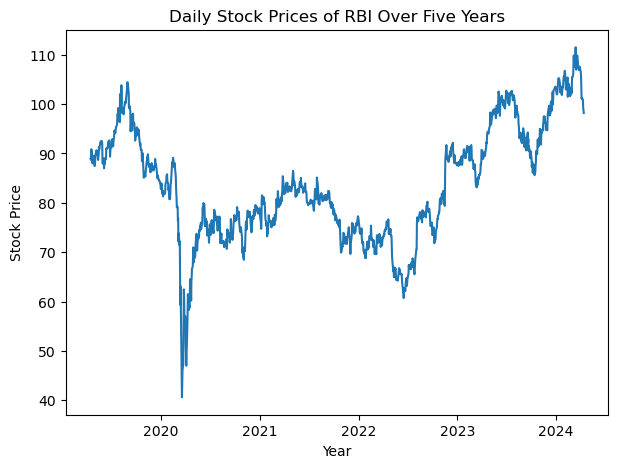

In [74]:

EV =  49.07 
Debt = 14.47 

# 
future_debt = 14.47*np.exp(0.035)
print(future_debt)

# for the AC.TO.csv file, only consider the close price, calculate the volatility (yearly) of the stock

df_ac_s= pd.read_csv('QSR.TO.csv')
equity_vol = df_ac_s['Close'].pct_change().std() * np.sqrt(252)
asset_vol = 0.2115

# create a df with first column consists of EV, Debt Value, Equity Volatility, Asset Volatility, and the second column as the 
# respective values

rb_stats = pd.DataFrame({'Value': [EV, Debt, equity_vol, asset_vol]}, index=['EV', 'Debt', 'Equity Volatility', 'Asset Volatility'])
rb_stats

df_ac_s['Date'] = pd.to_datetime(df_ac_s['Date'])
df_ac_s.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(7, 5))
plt.plot(df_ac_s.index, df_ac_s['Close'])

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Daily Stock Prices of RBI Over Five Years')

plt.show()











In [58]:
def merton_model(K,V, sigma, time_periods, interest):
    """ 
    Given K: Debt Value, V: Firm Value, sigma: Asset Volatility, time_periods: list of time periods, interest: risk free rate
    Returns the probability of default at each time period
    """
    prob_default = []
    for i in range(len(time_periods)):
        # d1 = -np.log(K*np.exp(-interest*time_periods[i])/V) / (sigma* np.sqrt(time_periods[i])) + 1/2 * sigma * np.sqrt(time_periods[i])
        # d2 = d1 - sigma * np.sqrt(time_periods[i])
        # normal cdf
        
        distance_to_default = np.log(V/(K*np.exp(-interest*time_periods[i]))) + (interest + sigma**2/2)*time_periods[i] / (sigma * np.sqrt(time_periods[i]))
        # prob_default.append(1- norm.cdf(d2))
        prob_default.append(1-norm.cdf(distance_to_default))
        
    return prob_default

In [59]:
V =  49.07 
K = 14.47 
sigma = 0.2115
interest = 0.035

prob_list = merton_model(K,V, sigma, time_stamps, interest)
print(prob_list)

# creat a dict called dict_rb_kmv with keys as the dates and values as the probability of default at each time period
dict_rb_kmv = {}
for i in range(len(df_rb)):
    dict_rb_kmv[df_rb['Date'][i]] = prob_list[i]



cum_prob_kmv = {}
cum_prob_kmv[df_rb['Date'][0]] = dict_rb_kmv[df_rb['Date'][0]]
for i in range(1, len(df_rb)):
    cum_prob_kmv[df_rb['Date'][i]] = cum_prob_kmv[df_rb['Date'][i-1]] + (1-cum_prob_kmv[df_rb['Date'][i-1]]) * dict_rb_kmv[df_rb['Date'][i]]

cum_prob_kmv

[0.08057997853403331, 0.06602506190687607, 0.056164625698141846, 0.04859703718058417, 0.04247365913456225, 0.03737051155430393, 0.03303706017277519, 0.029309409150872323, 0.0260727311061012, 0.023242514512505807, 0.01960698959845275]


{'2024-09-01': 0.08057997853403331,
 '2025-03-01': 0.1412847423697451,
 '2025-09-01': 0.1895141633958318,
 '2026-03-01': 0.22890137373162142,
 '2026-09-01': 0.26165275394287374,
 '2027-03-01': 0.28924516823274005,
 '2027-09-01': 0.3127264183779257,
 '2028-03-01': 0.33287000098027253,
 '2028-09-01': 0.35026390205752744,
 '2029-03-01': 0.36536540274325424,
 '2029-12-01': 0.3778086766904855}

## PLOTS


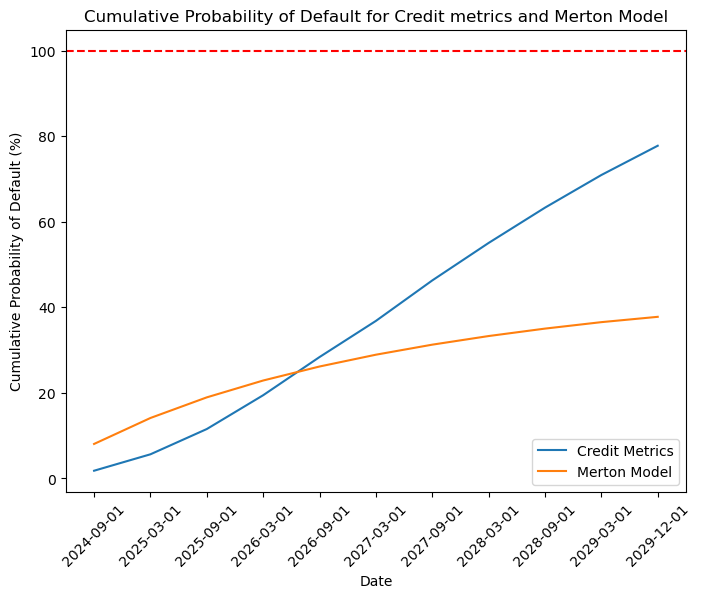

In [75]:
## plot the cumulative probability of default for both the models, y axis be percentage with the percentage sign


plt.figure(figsize=(8, 6))

plt.plot(df_rb['Date'], [i*100 for i in cum_prob_cm.values()], label='Credit Metrics')
plt.plot(df_rb['Date'], [i*100 for i in cum_prob_kmv.values()], label='Merton Model')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Cumulative Probability of Default (%)')
plt.title('Cumulative Probability of Default for Credit metrics and Merton Model')
plt.legend()
## add a dashed line at the probability = 1 place
plt.axhline(y=100, color='r', linestyle='--')





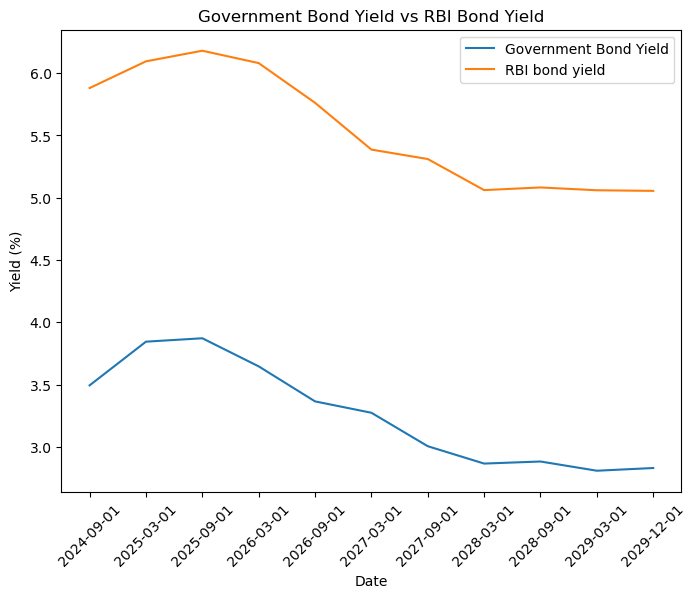

In [62]:
## plot the yield curve 

plt.figure(figsize=(8, 6))
plt.plot(df_rf['Date'], df_rf['Rate'] * 100, label='Government Bond Yield')
plt.plot(df_rb['Date'], df_rb['Rate'] *100, label='RBI bond yield')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Yield (%)')
plt.title('Government Bond Yield vs RBI Bond Yield')
plt.legend()




